# 📊 Análisis Exploratorio de Datos Clínicos (NHANES)

## 🎯 Objetivo
Este notebook realiza un **Análisis Exploratorio de Datos (EDA)** exhaustivo sobre el dataset clínico procesado de NHANES (National Health and Nutrition Examination Survey).

El objetivo principal es validar la calidad de los datos, entender las distribuciones de los nuevos biomarcadores clínicos y evaluar su poder predictivo frente a la variable objetivo: **Enfermedad Cardíaca (HeartDisease)**.

## 🛠️ Herramientas Utilizadas
- **Pandas**: Para manipulación y estructuración de datos.
- **Sweetviz**: Para generación automática de reportes visuales comparativos.
- **Matplotlib/Seaborn**: Para análisis de correlaciones y visualizaciones específicas.

## 📋 Flujo de Trabajo
1. **Carga de Datos**: Importar el dataset `process_data.parquet`.
2. **Estandarización**: Renombrar variables al inglés estándar médico.
3. **Análisis Estadístico**: Validar rangos, promedios y desviaciones.
4. **Correlación**: Identificar multicolinealidad entre variables.
5. **Reporte Automático**: Generar HTML con `Sweetviz` para análisis visual profundo.

In [ ]:
# Instalación de dependencias si es necesario
# !pip install sweetviz pandas pyarrow matplotlib seaborn

In [1]:
import pandas as pd
import sweetviz as sv
import matplotlib.pyplot as plt
import seaborn as sns

# Configuración de visualización
pd.set_option('display.max_columns', None)


c:\Users\OMAR\miniconda3\envs\xgb_env\lib\site-packages\sweetviz\graph.py:8: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import resource_filename


## 1. Carga y Preparación de Datos

En esta sección cargamos los datos procesados. El formato **Parquet** se utiliza por su eficiencia en lectura y escritura, preservando los tipos de datos.

Además, definimos un diccionario de mapeo para traducir las columnas de su nombre original en el dataset procesado (muchas veces en español o códigos) a nombres técnicos en inglés estandarizados (ej. `Presion_Sistolica` -> `SystolicBP`). Esto facilita la interoperabilidad con librerías de ML y la consistencia en el proyecto.

In [2]:
DATA_PATH = "../data/02_intermediate/process_data.parquet"

try:
    df = pd.read_parquet(DATA_PATH)
    print(f"Datos cargados correctamente. Dimensiones: {df.shape}")
except FileNotFoundError:
    print(f"Error: No se encontró el archivo en {DATA_PATH}")
    # Fallback para desarrollo si el path cambia
    # df = pd.read_parquet("../data/processed/NHANES_ULTIMATE_CLEAN.parquet")

Datos cargados correctamente. Dimensiones: (9000, 27)


In [3]:
# Mapeo de columnas a nombres en inglés (Todas las variables disponibles)
rename_dict = {
    'Sexo': 'Sex',
    'Edad': 'Age',
    'Raza': 'Race',
    'Educacion': 'Education',
    'Ingresos_Ratio': 'IncomeRatio',
    'TARGET': 'HeartDisease',
    'Presion_Sistolica': 'SystolicBP',
    'BMI': 'BMI',
    'Cintura': 'WaistCircumference',
    'Altura': 'Height',
    'Colesterol_Total': 'TotalCholesterol',
    'Trigliceridos': 'Triglycerides',
    'LDL': 'LDL',
    'HbA1c': 'HbA1c',
    'Glucosa': 'Glucose',
    'Creatinina': 'Creatinine',
    'Acido_Urico': 'UricAcid',
    'Enzima_ALT': 'ALT',
    'Albumina': 'Albumin',
    'Potasio': 'Potassium',
    'Sodio': 'Sodium',
    'Enzima_GGT': 'GGT',
    'Enzima_AST': 'AST',
    'Fumador': 'Smoking',
    'Actividad_Fisica': 'PhysicalActivity',
    'Seguro_Medico': 'HealthInsurance'
}

df_english = df.rename(columns=rename_dict)

# Eliminar columnas de identificación si existen (ej. SEQN)
if 'SEQN' in df_english.columns:
    df_english = df_english.drop(columns=['SEQN'])

# Asegurar que el Target sea binario (0/1)
if 'HeartDisease' in df_english.columns:
    df_english['HeartDisease'] = df_english['HeartDisease'].astype(int)

# Usar todas las columnas disponibles para el análisis (Sin filtrado)
# El objetivo es tener una visión holística
df_analysis = df_english.copy()

print(f"Columnas para análisis (Total: {len(df_analysis.columns)}):")
print(df_analysis.columns.tolist())

# Mantenimiento de listas para compatibilidad con celdas posteriores del notebook

# Detectar automáticamente variables numéricas para la matriz de correlación
numeric_cols = df_analysis.select_dtypes(include=['number']).columns.tolist()
if 'HeartDisease' in numeric_cols:
    numeric_cols.remove('HeartDisease')

# 'biomarkers' se usa en la celda siguiente para .describe()
# Ahora incluye todas las variables numéricas (biomarcadores + demografía numérica etc.)
biomarkers = numeric_cols

# 'categorical_vars' para referencia
categorical_vars = df_analysis.select_dtypes(exclude=['number']).columns.tolist()
if 'HeartDisease' not in categorical_vars and 'HeartDisease' in df_analysis.columns:
    categorical_vars.append('HeartDisease')


Columnas para análisis (Total: 26):
['Sex', 'Age', 'Race', 'Education', 'IncomeRatio', 'HeartDisease', 'SystolicBP', 'BMI', 'WaistCircumference', 'Height', 'TotalCholesterol', 'Triglycerides', 'LDL', 'HbA1c', 'Glucose', 'Creatinine', 'UricAcid', 'ALT', 'Albumin', 'Potassium', 'Sodium', 'GGT', 'AST', 'Smoking', 'PhysicalActivity', 'HealthInsurance']


## 2. Validación Estadística y Detección de Outliers

Antes de modelar, es crítico entender la "forma" de nuestros datos. Utilizamos `.describe()` para obtener un resumen estadístico de las variables numéricas:
- **Count**: ¿Tenemos datos faltantes?
- **Mean/Std**: ¿Cuál es el valor típico y qué tanto varían los datos?
- **Min/Max**: ¿Existen valores fisiológicamente imposibles? (Ej. BMI < 10 o Glucosa = 0).

Este paso nos permite identificar errores de calidad de datos o necesidad de limpieza adicional.

In [4]:
# Estadísticas descriptivas de biomarcadores numéricos
numeric_cols = [c for c in biomarkers if c in df_analysis.columns]
desc = df_analysis[numeric_cols].describe()
print(desc)

# Chequeo rápido de valores nulos
print("\nValores Nulos:")
print(df_analysis.isnull().sum())

               Sex          Age         Race    Education   IncomeRatio  \
count  9000.000000  9000.000000  9000.000000  9000.000000  9.000000e+03   
mean      1.511444    49.414111     3.180556     3.567111  2.537414e+00   
std       0.499897    17.311490     1.195223     1.222518  1.633314e+00   
min       1.000000    20.000000     1.000000     1.000000  5.397605e-79   
25%       1.000000    35.000000     3.000000     3.000000  1.110000e+00   
50%       2.000000    49.500000     3.000000     4.000000  2.160000e+00   
75%       2.000000    63.000000     4.000000     5.000000  4.100000e+00   
max       2.000000    80.000000     5.000000     9.000000  5.000000e+00   

        SystolicBP          BMI  WaistCircumference       Height  \
count  9000.000000  9000.000000         9000.000000  9000.000000   
mean    123.325759    29.320311           99.825889   167.290971   
std      18.237568     7.077553           16.880521     9.889659   
min      64.666667    15.400000           63.100000 

## 3. Análisis de Correlación (Pearson)

Buscamos **multicolinealidad** (variables que explican lo mismo) y relaciones fuertes con el target.
- Usamos el coeficiente de correlación de **Pearson**.
- Un valor cercano a **1** indica correlación positiva fuerte.
- Un valor cercano a **-1** indica correlación negativa fuerte.
- Un valor cercano a **0** indica ausencia de relación lineal.

**Nota**: Variables muy correlacionadas (ej. `SystolicBP` y `DiastolicBP`) podrían introducir redundancia en ciertos modelos lineales, aunque algoritmos de árboles como XGBoost suelen manejarlas bien.

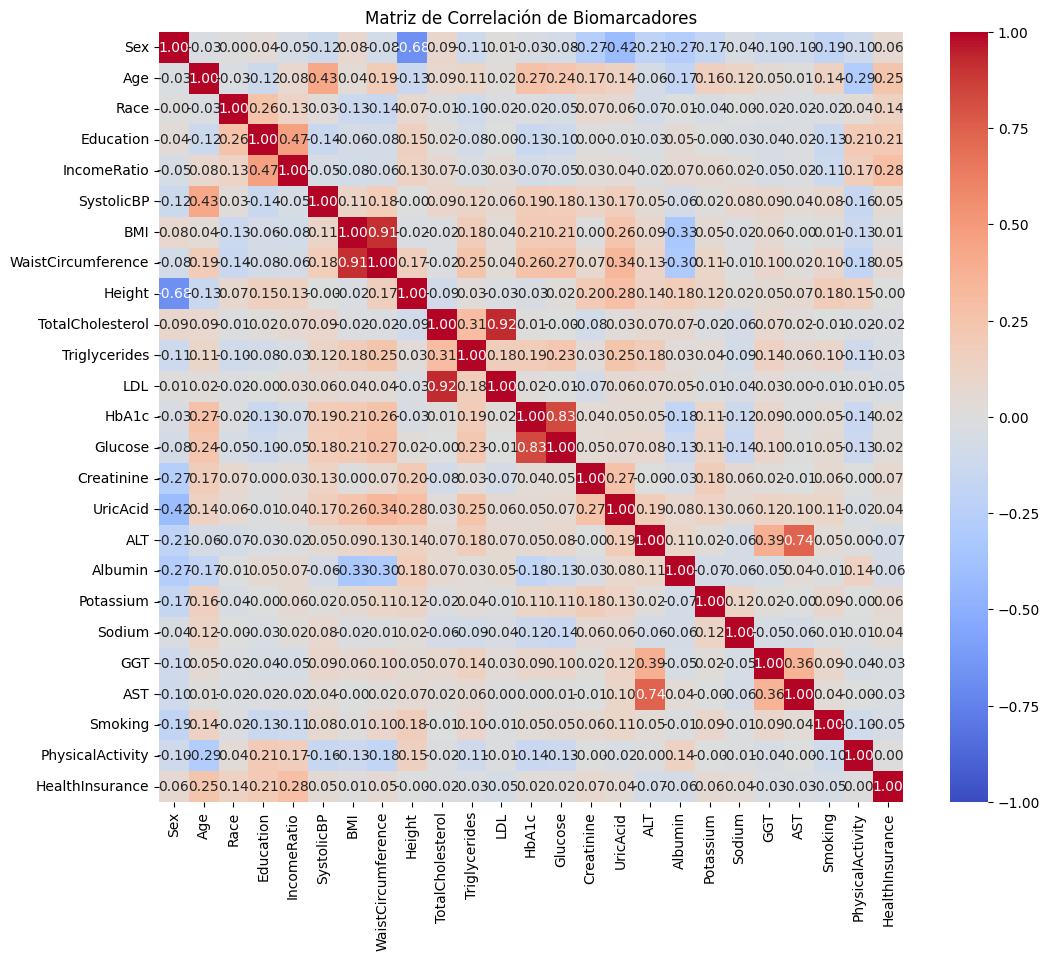

In [5]:
plt.figure(figsize=(12, 10))
corr_matrix = df_analysis[numeric_cols].corr()
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Matriz de Correlación de Biomarcadores")
plt.show()

## 4. Reporte Automatizado con Sweetviz

Generamos un reporte HTML interactivo utilizando la librería `Sweetviz`.
- **Target**: `HeartDisease` (0 = Sano, 1 = Enfermo).
- **Objetivo**: Comparar las distribuciones de cada feature para ambas clases.
- **Interpretación**: Si las curvas de distribución para clase 0 y 1 se separan significativamente en una variable, esa variable es un buen predictor.

El reporte se guardará como `NHANES_Clinical_Analysis.html` y puede abrirse en cualquier navegador web.

In [6]:
target_col = 'HeartDisease'

if target_col in df_analysis.columns:
    # Configuración de Sweetviz
    # pairwise_analysis='off' para eficiencia si hay muchas columnas, aunque aquí hemos filtrado.
    report = sv.analyze(
        df_analysis, 
        target_feat=target_col, 
        pairwise_analysis='off'
    )
    
    output_file = "NHANES_Clinical_Analysis.html"
    report.show_html(output_file)
    print(f"Reporte generado exitosamente: {output_file}")
else:
    print(f"Error: La variable objetivo '{target_col}' no se encuentra en el dataframe.")

                                             |          | [  0%]   00:00 -> (? left)

Report NHANES_Clinical_Analysis.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.
Reporte generado exitosamente: NHANES_Clinical_Analysis.html
